In [1]:
import torch.nn.functional as F
import torch
from torch import nn
from dataset import BratsDataset
from training_loop import train_model
from basic_unet import UNet
from torchvision import transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 1

def load_dataset():
    transform = transforms.Compose([])
    train_dataset = BratsDataset(Path('data/processed'), transform=transform, test=False)
    test_dataset = BratsDataset(Path('data/processed'), transform=transform, test=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return train_loader, test_loader

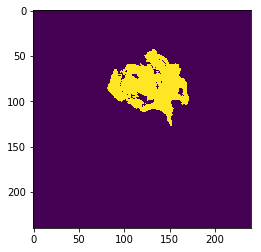

6.1407958e-12 0.005359078 0.00026566483


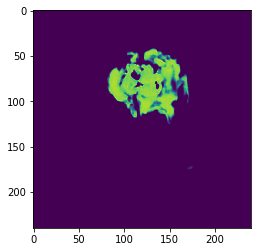

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = load_dataset()

model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

#sample = next(iter(test_loader))

for sample in test_loader:
    segment = sample['segment']
    segment = segment.squeeze()
    plt.imshow(segment)
    plt.show()

    image = sample['input'].to(device)
    output = model(image)
    output = torch.sigmoid(output.detach()).cpu().squeeze().numpy()
    print(output.min(), output.max(), output.mean())
    #output = (output > output.mean())
    plt.imshow(output)
    plt.show()
    break